In [26]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn import datasets
import sklearn
import tqdm
%matplotlib inline

# torch.manual_seed(1)    # reproducible

In [2]:
def two_moons(N=10):
    x = sklearn.datasets.make_moons(n_samples=N, shuffle=False, noise=0.1, random_state=None)
    xTr = x[0]
    yTr = x[1]
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

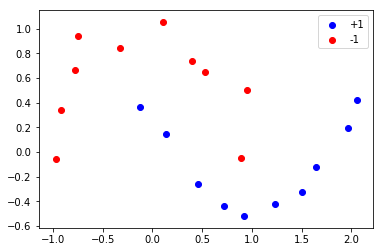

In [3]:
xTr,yTr,xTe,yTe=two_moons(40)
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [4]:
def validation_error(model,x,y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y)
    x = x.contiguous()
    x = x.view(-1,2)
    x, y = Variable(x), Variable(y)
    
    
    Z = (F.softmax(model(x)))
    Z = Z.log().data.numpy()
    y = np.eye(2)[y.data.numpy()]
    Z = -np.multiply(Z,y).sum(1)
    return Z.sum()/Z.shape[0]

In [5]:
# def adjust_learning_rate(lr,epoch,optimizer,total_epoch):  
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr*np.cos(epoch*np.pi/(2.0*total_epoch))
        
# #         param_group['lr'] = lr*(0.5** (epoch // (total_epoch/3)))*(0.5** (epoch // (total_epoch/2))) * (0.5 ** (epoch //(total_epoch*(3/4))))
#     return optimizer.param_groups[0]['lr']

In [6]:
def adjust_learning_rate(lr,epoch,optimizer,total_epoch):  
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr*(0.5** (epoch // (total_epoch/3)))*(0.5** (epoch // (total_epoch/2))) * (0.5 ** (epoch //(total_epoch*(3/4))))
    return optimizer.param_groups[0]['lr']

In [7]:
def train(model,total_epoch,xTr,yTr,xTe,yTe,lr=0.02,adjust=False,plot=True):
    # torch can only train on Variable, so convert them to Variable
    x = torch.from_numpy(xTr).float()
    y = torch.from_numpy(yTr)
    x = x.contiguous()
    x = x.view(-1,2)
    x, y = Variable(x), Variable(y)

    xt = torch.from_numpy(xTe).float()
    yt = torch.from_numpy(yTe)
    xt = xt.view(-1,2)
    xt, yt = Variable(xt), Variable(yt)
    
    
    print('Number of model parameters: {}'.format(
            sum([p.data.nelement() for p in model.parameters()])))
    
    
    min_val = 0
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
    
    loss_data = []
    validation_loss_data = []
    for epoch in range(total_epoch):

        if adjust:
            lr = adjust_learning_rate(lr,epoch,optimizer,total_epoch)
#         print(epoch, lr)
        out = model(x)                 # input x and predict based on x
        loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
    #     print(out)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
#         print(lr)
        loss_data.append(loss.data[0])
        

        current_val = validation_error(model,xTe,yTe)
        
        
        if epoch == 1:
            min_val = validation_loss_data[0]
        validation_loss_data.append(current_val)
#         if epoch >2 and current_val >validation_loss_data[-2]:
#             break
        min_val = min(min_val,validation_loss_data[-1])

    if plot:
        print(loss_data[-1],validation_loss_data[-1])
        print('min validation error',min_val)
        figure = plt.figure(figsize=(20, 5))
        plt.subplot(1, 2 + 1, 1)
        plt.plot(loss_data)
        plt.title('Training loss vs Epoch')

        plt.subplot(1, 2 + 1, 2)
        plt.plot(validation_loss_data)
        plt.title('Validation loss vs Epoch')
    

In [8]:
class DenseLayer(nn.Module):
    def __init__(self,in_planes,n_hidden,dropRate):
        super(DenseLayer,self).__init__()
        self.Denselayer = nn.Linear(in_planes,n_hidden)
    
    def forward(self,x):
        out = self.Denselayer(x)
        out = F.relu(out)
#         self.get_features(out)
        return torch.cat([x, out], 1)
    
    def get_features(self,out):
        print((F.softmax(out)).size())
        return F.softmax(out)

class dense_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,dropRate,growth_rate):
        super(dense_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.in_planes = in_planes
        self.layer = self._make_layer(nb_layers,in_planes,dropRate,num_classes,growth_rate)
        self.out = nn.Linear(in_planes+nb_layers*growth_rate,num_classes)
        self.inter_features = []
        
    def _make_layer(self,nb_layers,in_planes,dropRate,num_classes,growth_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(DenseLayer(in_planes+i*growth_rate, growth_rate,dropRate))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
        x = self.out(x)
        return (x)
    
    def get_features(self,x,inter_features):
        print(len(self.layer))
        #first layer
        temp = self.layer[0](x)
        inter_features.append(temp)
        for i in range(1,len(self.layer)):
            tmp = inter_features[-1]
            print(tmp.size())
            out = self.layer[i](tmp)
#             out = out.narrow(1,2+(i-1)*4,4)
            inter_features.append(out)
#         inter_features.append(self.layer[0](x))
#         print(self.layer[0](x))

In [9]:
class fc_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,n_hidden,dropRate):
        super(fc_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.n_hidden = n_hidden
        self.layer = self._make_layer(nb_layers, in_planes,n_hidden, dropRate,num_classes)
        self.out = nn.Linear(n_hidden,num_classes)
    
    def _make_layer(self,nb_layers,in_planes,n_hidden,dropRate,num_classes):
        layers = []
        for i in range(nb_layers):
            if i == 0:
                layers.append(nn.Linear(in_planes, n_hidden))
                layers.append(nn.ReLU(inplace=True))
            else:
                layers.append(nn.Linear(n_hidden, n_hidden))
                layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
#         x = F.relu(x)
        return self.out(x)

In [10]:
# torch.manual_seed(1)
# model_2 = fc_model(2,4,2,12,0.2)
# train(model_2,1000,xTr,yTr,xTe,yTe,0.08,True)

In [11]:
# x = torch.from_numpy(xTr).float()
# y = torch.from_numpy(yTr)
# x = x.contiguous()
# x = x.view(-1,2)
# x, y = Variable(x), Variable(y)

In [12]:
# denseNet = dense_model(num_classes=2,nb_layers=15,in_planes= 2,dropRate = 0,growth_rate=4)
# intermediate_features = []
# denseNet.get_features(x,intermediate_features)


Number of model parameters: 1986
0.005795366130769253 0.0389348843617
min validation error 0.0376454402962


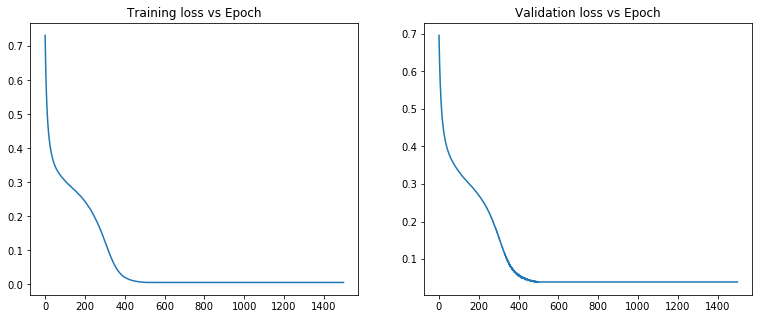

In [13]:
# torch.manual_seed(1)
denseNet = dense_model(num_classes=2,nb_layers=15,in_planes= 2,dropRate = 0,growth_rate=4)
train(denseNet,1500,xTr,yTr,xTe,yTe,0.08,True)


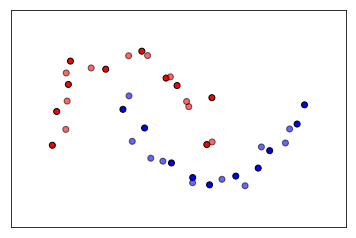

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

h = 0.02
x_min, x_max = xTr[:, 0].min() - .5, xTr[:, 0].max() + .5
y_min, y_max = xTr[:, 1].min() - .5, xTr[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 1, 1)


# Plot the training points
ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())



grid = np.c_[xx.ravel(), yy.ravel()]
# torch can only train on Variable, so convert them to Variable
grid = torch.from_numpy(grid).float()
# x = x.contiguous()

grid = Variable(grid)

In [17]:
np.zeros([5,11])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [38]:
dense_models = []

res = np.zeros([5,17])
for j in tqdm.trange(5):
    for i in tqdm.trange(3, 20):
        model_2 = fc_model(2,i,2,4,0.0)
        train(model_2,1000,xTr,yTr,xTe,yTe,0.08,True,False)
        res[j,i-4] = (validation_error(model_2,xTe,yTe))
        dense_models.append(denseNet)

    
    
# plt.plot(validation_error)

  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 62



  6%|▌         | 1/17 [00:01<00:18,  1.16s/it]

Number of model parameters: 82



 12%|█▏        | 2/17 [00:02<00:17,  1.19s/it]

Number of model parameters: 102



 18%|█▊        | 3/17 [00:03<00:17,  1.28s/it]

Number of model parameters: 122



 24%|██▎       | 4/17 [00:05<00:19,  1.50s/it]

Number of model parameters: 142



 29%|██▉       | 5/17 [00:08<00:20,  1.70s/it]

Number of model parameters: 162



 35%|███▌      | 6/17 [00:10<00:20,  1.89s/it]

Number of model parameters: 182



 41%|████      | 7/17 [00:12<00:20,  2.04s/it]

Number of model parameters: 202



 47%|████▋     | 8/17 [00:15<00:19,  2.19s/it]

Number of model parameters: 222



 53%|█████▎    | 9/17 [00:18<00:18,  2.36s/it]

Number of model parameters: 242



 59%|█████▉    | 10/17 [00:21<00:18,  2.64s/it]

Number of model parameters: 262



 65%|██████▍   | 11/17 [00:24<00:16,  2.77s/it]

Number of model parameters: 282



 71%|███████   | 12/17 [00:27<00:14,  2.92s/it]

Number of model parameters: 302



 76%|███████▋  | 13/17 [00:31<00:12,  3.08s/it]

Number of model parameters: 322



 82%|████████▏ | 14/17 [00:34<00:09,  3.25s/it]

Number of model parameters: 342



 88%|████████▊ | 15/17 [00:38<00:06,  3.42s/it]

Number of model parameters: 362



 94%|█████████▍| 16/17 [00:42<00:03,  3.60s/it]

Number of model parameters: 382



  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 62



  6%|▌         | 1/17 [00:01<00:17,  1.09s/it]

Number of model parameters: 82



 12%|█▏        | 2/17 [00:02<00:18,  1.22s/it]

Number of model parameters: 102



 18%|█▊        | 3/17 [00:04<00:18,  1.31s/it]

Number of model parameters: 122



 24%|██▎       | 4/17 [00:05<00:18,  1.42s/it]

Number of model parameters: 142



 29%|██▉       | 5/17 [00:07<00:18,  1.55s/it]

Number of model parameters: 162



 35%|███▌      | 6/17 [00:09<00:19,  1.75s/it]

Number of model parameters: 182



 41%|████      | 7/17 [00:12<00:20,  2.02s/it]

Number of model parameters: 202



 47%|████▋     | 8/17 [00:15<00:20,  2.26s/it]

Number of model parameters: 222



 53%|█████▎    | 9/17 [00:18<00:19,  2.41s/it]

Number of model parameters: 242



 59%|█████▉    | 10/17 [00:21<00:18,  2.64s/it]

Number of model parameters: 262



 65%|██████▍   | 11/17 [00:24<00:17,  2.86s/it]

Number of model parameters: 282



 71%|███████   | 12/17 [00:27<00:14,  2.98s/it]

Number of model parameters: 302



 76%|███████▋  | 13/17 [00:31<00:12,  3.11s/it]

Number of model parameters: 322



 82%|████████▏ | 14/17 [00:35<00:10,  3.39s/it]

Number of model parameters: 342



 88%|████████▊ | 15/17 [00:39<00:07,  3.67s/it]

Number of model parameters: 362



 94%|█████████▍| 16/17 [00:43<00:03,  3.77s/it]

Number of model parameters: 382



  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 62



  6%|▌         | 1/17 [00:01<00:17,  1.07s/it]

Number of model parameters: 82



 12%|█▏        | 2/17 [00:02<00:17,  1.14s/it]

Number of model parameters: 102



 18%|█▊        | 3/17 [00:03<00:17,  1.24s/it]

Number of model parameters: 122



 24%|██▎       | 4/17 [00:05<00:17,  1.37s/it]

Number of model parameters: 142



 29%|██▉       | 5/17 [00:07<00:18,  1.54s/it]

Number of model parameters: 162



 35%|███▌      | 6/17 [00:09<00:19,  1.76s/it]

Number of model parameters: 182



 41%|████      | 7/17 [00:12<00:19,  1.95s/it]

Number of model parameters: 202



 47%|████▋     | 8/17 [00:14<00:19,  2.13s/it]

Number of model parameters: 222



 53%|█████▎    | 9/17 [00:17<00:18,  2.31s/it]

Number of model parameters: 242



 59%|█████▉    | 10/17 [00:20<00:17,  2.49s/it]

Number of model parameters: 262



 65%|██████▍   | 11/17 [00:23<00:15,  2.66s/it]

Number of model parameters: 282



 71%|███████   | 12/17 [00:26<00:14,  2.84s/it]

Number of model parameters: 302



 76%|███████▋  | 13/17 [00:30<00:12,  3.02s/it]

Number of model parameters: 322



 82%|████████▏ | 14/17 [00:33<00:09,  3.20s/it]

Number of model parameters: 342



 88%|████████▊ | 15/17 [00:37<00:06,  3.38s/it]

Number of model parameters: 362



 94%|█████████▍| 16/17 [00:41<00:03,  3.57s/it]

Number of model parameters: 382



  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 62



  6%|▌         | 1/17 [00:01<00:17,  1.09s/it]

Number of model parameters: 82



 12%|█▏        | 2/17 [00:02<00:17,  1.15s/it]

Number of model parameters: 102



 18%|█▊        | 3/17 [00:03<00:17,  1.25s/it]

Number of model parameters: 122



 24%|██▎       | 4/17 [00:05<00:18,  1.39s/it]

Number of model parameters: 142



 29%|██▉       | 5/17 [00:07<00:18,  1.53s/it]

Number of model parameters: 162



 35%|███▌      | 6/17 [00:09<00:19,  1.76s/it]

Number of model parameters: 182



 41%|████      | 7/17 [00:12<00:20,  2.03s/it]

Number of model parameters: 202



 47%|████▋     | 8/17 [00:15<00:20,  2.26s/it]

Number of model parameters: 222



 53%|█████▎    | 9/17 [00:17<00:19,  2.41s/it]

Number of model parameters: 242



 59%|█████▉    | 10/17 [00:21<00:18,  2.62s/it]

Number of model parameters: 262



 65%|██████▍   | 11/17 [00:24<00:17,  2.88s/it]

Number of model parameters: 282



 71%|███████   | 12/17 [00:27<00:14,  3.00s/it]

Number of model parameters: 302



 76%|███████▋  | 13/17 [00:31<00:12,  3.13s/it]

Number of model parameters: 322



 82%|████████▏ | 14/17 [00:34<00:09,  3.28s/it]

Number of model parameters: 342



 88%|████████▊ | 15/17 [00:38<00:06,  3.44s/it]

Number of model parameters: 362



 94%|█████████▍| 16/17 [00:42<00:03,  3.61s/it]

Number of model parameters: 382



  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 62



  6%|▌         | 1/17 [00:01<00:17,  1.09s/it]

Number of model parameters: 82



 12%|█▏        | 2/17 [00:02<00:17,  1.15s/it]

Number of model parameters: 102



 18%|█▊        | 3/17 [00:03<00:17,  1.25s/it]

Number of model parameters: 122



 24%|██▎       | 4/17 [00:05<00:17,  1.38s/it]

Number of model parameters: 142



 29%|██▉       | 5/17 [00:07<00:18,  1.53s/it]

Number of model parameters: 162



 35%|███▌      | 6/17 [00:09<00:18,  1.69s/it]

Number of model parameters: 182



 41%|████      | 7/17 [00:11<00:18,  1.88s/it]

Number of model parameters: 202



 47%|████▋     | 8/17 [00:14<00:18,  2.08s/it]

Number of model parameters: 222



 53%|█████▎    | 9/17 [00:17<00:18,  2.27s/it]

Number of model parameters: 242



 59%|█████▉    | 10/17 [00:19<00:17,  2.46s/it]

Number of model parameters: 262



 65%|██████▍   | 11/17 [00:23<00:15,  2.65s/it]

Number of model parameters: 282



 71%|███████   | 12/17 [00:26<00:14,  2.83s/it]

Number of model parameters: 302



 76%|███████▋  | 13/17 [00:29<00:12,  3.01s/it]

Number of model parameters: 322



 82%|████████▏ | 14/17 [00:33<00:09,  3.28s/it]

Number of model parameters: 342



 88%|████████▊ | 15/17 [00:37<00:07,  3.51s/it]

Number of model parameters: 362



 94%|█████████▍| 16/17 [00:41<00:03,  3.66s/it]

Number of model parameters: 382



100%|██████████| 5/5 [03:53<00:00, 46.59s/it]


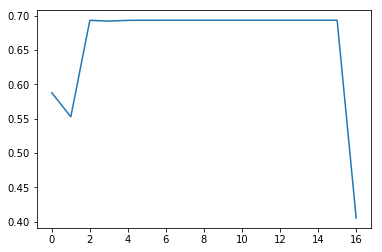

In [40]:
plt.plot(np.mean(res, 0))

In [45]:
res

array([[ 0.45968428,  0.33440406,  0.6923644 ,  0.69232331,  0.69313914,
         0.69307236,  0.69314718,  0.69314785,  0.69314755,  0.69314721,
         0.69314722,  0.69314721,  0.69314721,  0.69314719,  0.69314718,
         0.69314718,  0.34159184],
       [ 0.69314718,  0.69314721,  0.69314721,  0.69314736,  0.69314721,
         0.69314721,  0.6931354 ,  0.69314509,  0.69314719,  0.69314721,
         0.69314717,  0.69314721,  0.69314718,  0.69314718,  0.69314715,
         0.69314718,  0.34638241],
       [ 0.67487776,  0.69314718,  0.69315466,  0.68788719,  0.6931589 ,
         0.69314695,  0.69314718,  0.69314719,  0.69314709,  0.69314721,
         0.69314721,  0.69314721,  0.69314715,  0.69314718,  0.69314721,
         0.69314718,  0.30498315],
       [ 0.42113422,  0.3500409 ,  0.6931144 ,  0.69313514,  0.69314841,
         0.69314721,  0.69314953,  0.69314721,  0.6931472 ,  0.69314718,
         0.69314718,  0.69314702,  0.69314715,  0.6931471 ,  0.69314719,
         0.69314715

In [75]:
def visualize_layers(intermediate_features):
    for i in range(len(intermediate_features)):
        intermediate_features[i] = (intermediate_features[i].narrow(1,2+(i)*4,4))
    figure = plt.figure(figsize=(20, 20))
    k = 1
    for i in range(len(intermediate_features)):
        ax = plt.subplot(3, len(intermediate_features)/2, k)

#         grid = grid.view(-1,2)
        out = intermediate_features[i]
        out = F.softmax(out)
        Z = out.data.numpy()
        Z = Z[:,[1]]
        Z = Z.reshape(xx.shape)
        print(Z.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        plt.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
                   edgecolors='k',label="Training")
        k+=1

In [76]:
# net = dense_models[9]
# intermediate_features = []
# net.get_features(grid,intermediate_features)
# visualize_layers(intermediate_features)

In [72]:
dense_models = []

for i in tqdm.trange(3, 20):
    denseNet = dense_model(num_classes=2,nb_layers=i,in_planes= 2,dropRate = 0,growth_rate=9)

    train(denseNet,1000,xTr,yTr,xTe,yTe,0.08,True,False)
#         res[j,i-4] = (validation_error(model_2,xTe,yTe))
    dense_models.append(denseNet)

    
    


  0%|          | 0/17 [00:00<?, ?it/s]

Number of model parameters: 384



  6%|▌         | 1/17 [00:01<00:23,  1.49s/it]

Number of model parameters: 672



 12%|█▏        | 2/17 [00:03<00:22,  1.51s/it]

Number of model parameters: 1041



 18%|█▊        | 3/17 [00:05<00:23,  1.65s/it]

Number of model parameters: 1491



 24%|██▎       | 4/17 [00:07<00:23,  1.81s/it]

Number of model parameters: 2022


 29%|██▉       | 5/17 [00:09<00:24,  2.01s/it]

Number of model parameters: 2634


 35%|███▌      | 6/17 [00:12<00:24,  2.24s/it]

Number of model parameters: 3327


 41%|████      | 7/17 [00:15<00:25,  2.58s/it]

Number of model parameters: 4101


 47%|████▋     | 8/17 [00:20<00:27,  3.07s/it]

Number of model parameters: 4956


 53%|█████▎    | 9/17 [00:24<00:28,  3.54s/it]

Number of model parameters: 5892


 59%|█████▉    | 10/17 [00:28<00:26,  3.74s/it]

Number of model parameters: 6909


 65%|██████▍   | 11/17 [00:33<00:23,  3.93s/it]

Number of model parameters: 8007


 71%|███████   | 12/17 [00:38<00:21,  4.25s/it]

Number of model parameters: 9186


 76%|███████▋  | 13/17 [00:44<00:18,  4.70s/it]

Number of model parameters: 10446


 82%|████████▏ | 14/17 [00:49<00:14,  5.00s/it]

Number of model parameters: 11787


 88%|████████▊ | 15/17 [00:55<00:10,  5.13s/it]

Number of model parameters: 13209


 94%|█████████▍| 16/17 [01:01<00:05,  5.36s/it]

Number of model parameters: 14712


100%|██████████| 17/17 [01:07<00:00,  5.59s/it]


(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)
(26058,)
(129, 202)


ValueError: num must be 1 <= num <= 12, not 13

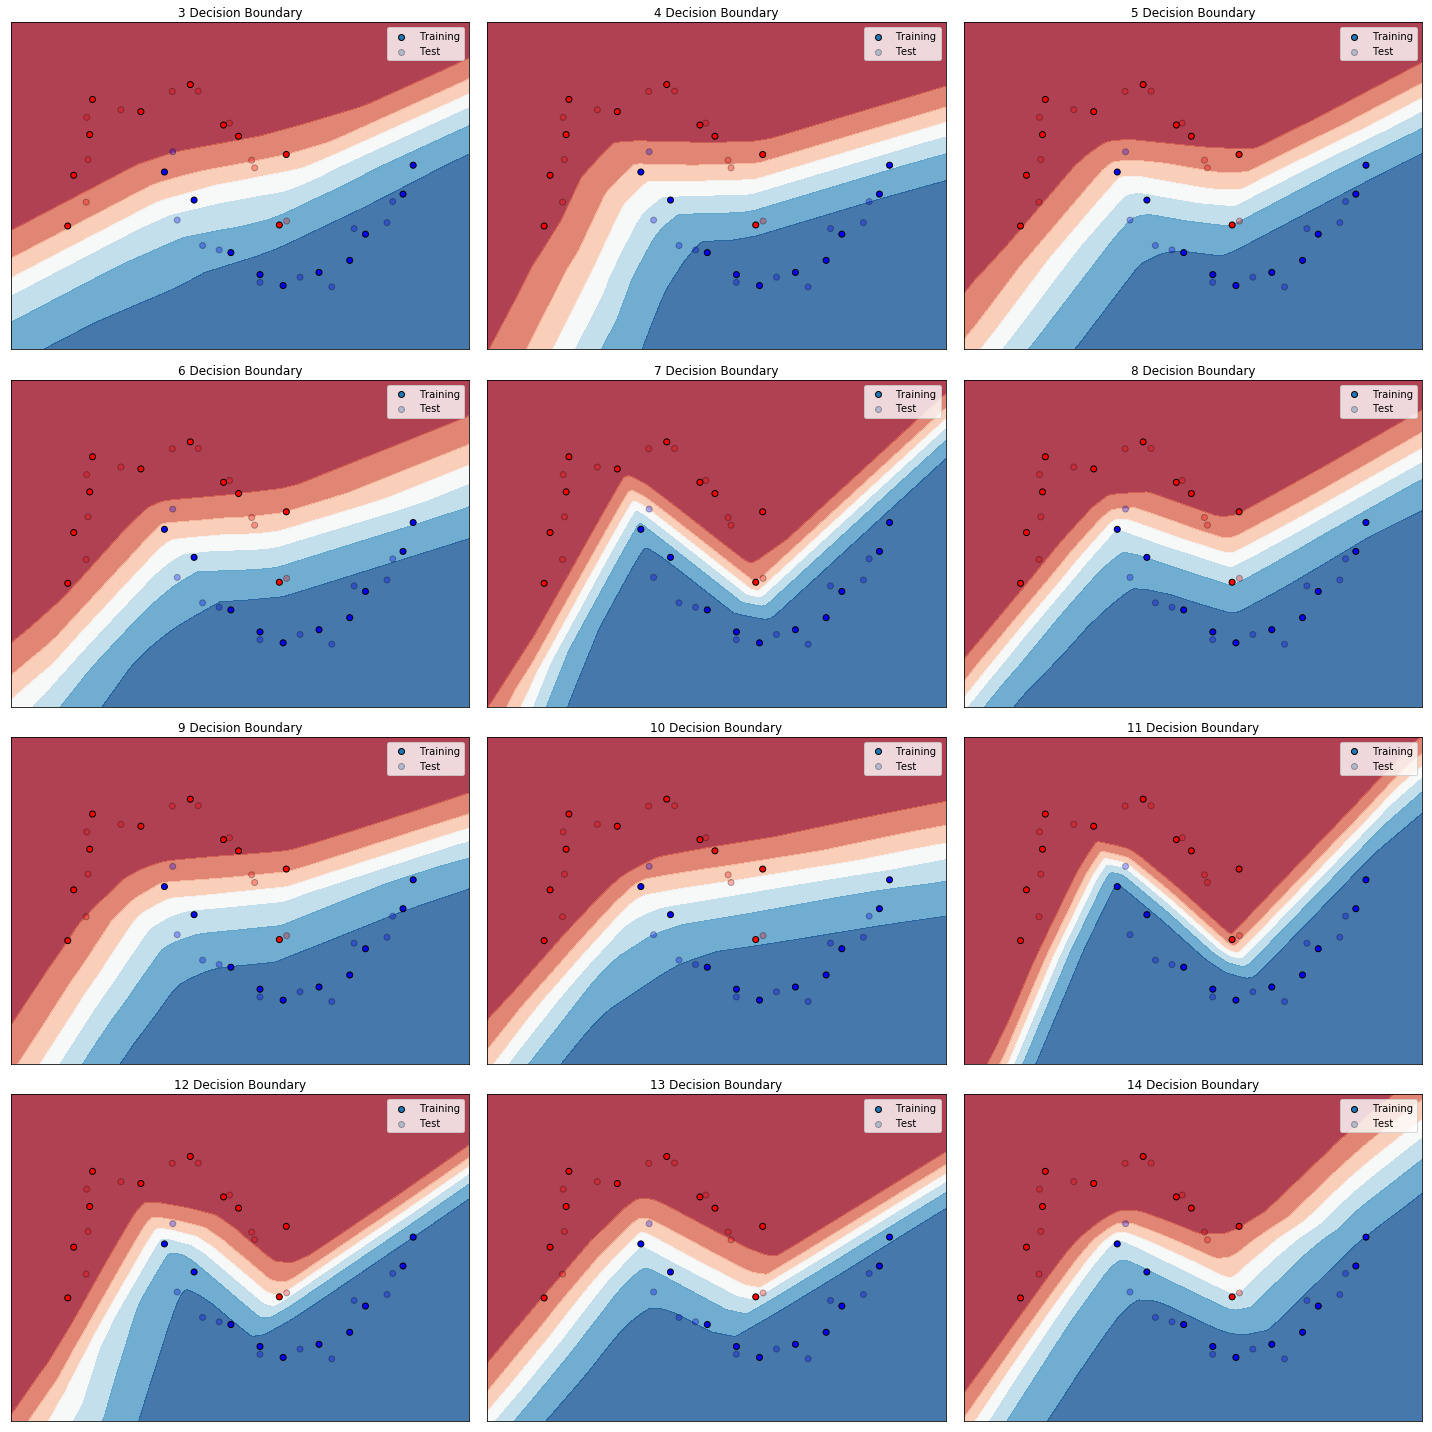

In [73]:
i = 1

figure = plt.figure(figsize=(20, 20))
for model in dense_models:
    grid = grid.view(-1,2)
         
#     print(len(model.layer))
    
    ax = plt.subplot(4, 3, i)
#     print(model)
    Z = F.softmax(model(grid))
#     print(Z)
#     Z = Z[:,1].data.numpy()
    Z = Z.data.numpy().reshape(-1,2)[:,1]
    print(Z.shape)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    print(Z.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
               edgecolors='k',label="Training")
    # and testing points
    ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright,
               edgecolors='k', alpha=0.3,label="Test")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(str(len(model.layer))+" Decision Boundary")
    plt.tight_layout()
    plt.legend()
#     print(i)
    i+=1
plt.show()

Number of model parameters: 530
0.0068809157237410545 0.0190570213963
min validation error 0.0190570213963


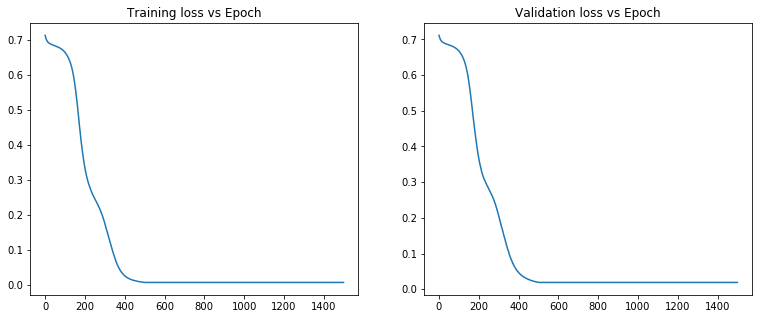

In [281]:

model_2 = fc_model(2,4,2,12,0.2)
train(model_2,1500,xTr,yTr,xTe,yTe,0.08,True)

In [68]:

linear_models = []

for i in range(2,11):
    model_2 = fc_model(2,i,2,4,0.0)
    train(model_2,1000,xTr,yTr,xTe,yTe,0.08,True,False)
    linear_models.append(model_2)
    print(validation_error(model_2,xTe,yTe))
    

    

Number of model parameters: 42
0.353451223345
Number of model parameters: 62
0.33382903412
Number of model parameters: 82
0.305931023834
Number of model parameters: 102
0.675640895963
Number of model parameters: 122
0.693069174886
Number of model parameters: 142
0.693186274171
Number of model parameters: 162
0.693146157265
Number of model parameters: 182
0.693147212267
Number of model parameters: 202
0.693147194386


4
(26058,)
1
6
(26058,)
2
8
(26058,)
3
10
(26058,)
4
12
(26058,)
5
14
(26058,)
6
16
(26058,)
7
18
(26058,)
8
20
(26058,)
9


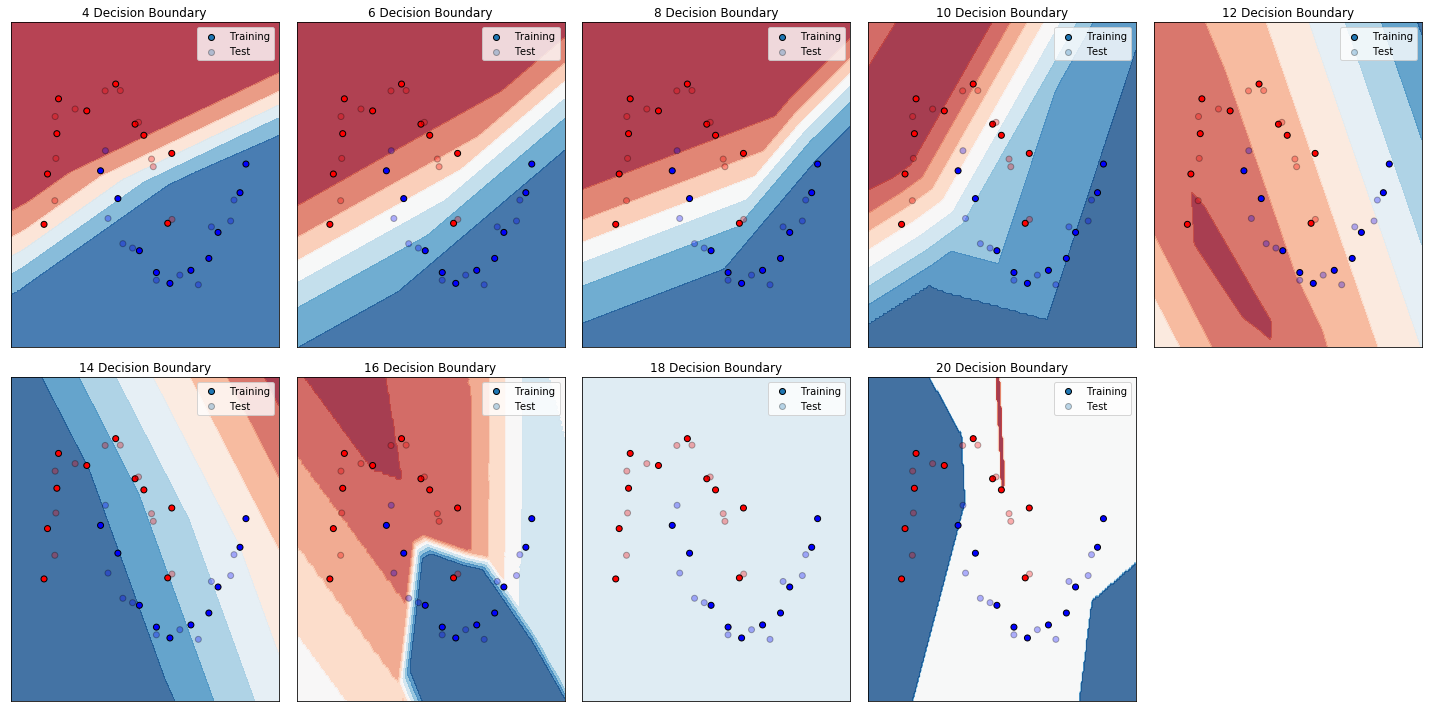

In [69]:
i = 1

figure = plt.figure(figsize=(20, 10))
for model in linear_models:
    grid = grid.view(-1,2)
         
    print(len(model.layer))
    
    ax = plt.subplot(2, (len(linear_models) + 1)//2, i)
#     print(model)
    Z = F.softmax(model(grid))
#     print(Z)
#     Z = Z[:,1].data.numpy()
    Z = Z.data.numpy().reshape(-1,2)[:,1]
    print(Z.shape)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
               edgecolors='k',label="Training")
    # and testing points
    ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright,
               edgecolors='k', alpha=0.3,label="Test")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(str(len(model.layer))+" Decision Boundary")
    plt.tight_layout()
    plt.legend()
    print(i)
    i+=1
plt.show()

In [ ]:
dense_model(num_classes=2,nb_layers=15,in_planes= 2,dropRate = 0,growth_rate=4)

In [58]:
model = dense_model(num_classes=2,nb_layers=4,in_planes= 2,dropRate = 0,growth_rate=4)
sum([p.data.nelement() for p in model.parameters()])

182

In [57]:
np.zeros([])

182

In [ ]:
layer*rate+(2x4)+6x4+10x4+14x4+

In [53]:
print(model)
for i in model.parameters():
    print(i)

dense_model (
  (layer): Sequential (
    (0): DenseLayer (
      (Denselayer): Linear (2 -> 4)
    )
    (1): DenseLayer (
      (Denselayer): Linear (6 -> 4)
    )
    (2): DenseLayer (
      (Denselayer): Linear (10 -> 4)
    )
    (3): DenseLayer (
      (Denselayer): Linear (14 -> 4)
    )
  )
  (out): Linear (18 -> 2)
)
Parameter containing:
 0.0777 -0.2997
-0.6157 -0.5510
-0.2635  0.5690
 0.1159  0.1320
[torch.FloatTensor of size 4x2]

Parameter containing:
 0.5751
 0.2002
 0.5109
-0.6655
[torch.FloatTensor of size 4]

Parameter containing:
 0.2364  0.1099 -0.0692 -0.3916 -0.3799 -0.0020
 0.3218  0.0625  0.0671  0.0718  0.1215  0.2174
-0.0438 -0.4081  0.2232  0.0886 -0.3987 -0.0856
 0.1225 -0.0966 -0.1557  0.2199 -0.1585  0.3274
[torch.FloatTensor of size 4x6]

Parameter containing:
 0.3078
-0.2047
-0.1542
-0.0975
[torch.FloatTensor of size 4]

Parameter containing:
 0.0934 -0.2603  0.1073  0.1436 -0.2127  0.2912  0.2285  0.1167  0.1992  0.2744
 0.1402 -0.0095 -0.0064 -0.2778  0